# Visualize vanilla LIME and robust LIME in the PCA and t-SNE spaces

1. Load COMPAS dataset
2. Generate synthetic neighborhood via vanilla LIME
    * Can be done via [this LIME tabular method](https://github.com/marcotcr/lime/blob/2ba75c188dcffe3e926c093efc5d03a0d51692b6/lime/lime_tabular.py#L468)
3. Generate synthetic neighborhood via robust LIME (CTGAN)
4. Reduce the original dataset, vanilla LIME neighborhood, and robust LIME neighborhood to 2-D using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
    * Tips on t-SNE: https://distill.pub/2016/misread-tsne/
5. Plot

In [1]:
%matplotlib inline
import os
import sys

sys.path.append('../')

from experiments.utils.datasets import get_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Explainers
from lime.lime_tabular import LimeTabularExplainer
from faster_lime.explainers.numpy_robust_tabular_explainer import NumpyRobustTabularExplainer

# d reduction utilities
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. Load dataset
data = get_dataset('compas', {})
df = data['data']
numerical_ft = [0,2,3]
categorical_ft = list(set(range(9)).difference(set(numerical_ft)))
num_samples_vanilla = 2
num_data_local_neigbourhood = 250

In [2]:
df.head()

,age,two_year_recid,priors_count,length_of_stay,c_charge_degree_F,c_charge_degree_M,sex_Female,sex_Male,race
id,,,,,,,,,
1,69,0,0,0,1,0,0,1,0
3,34,1,0,10,1,0,0,1,1
4,24,1,4,1,1,0,0,1,1
7,44,0,0,1,0,1,0,1,0
8,41,1,14,6,1,0,0,1,0


In [3]:
df['two_year_recid'].unique()

array([0, 1])

# Generate vanilla LIME synthetic neighborhood

In [4]:
tabular_vanilla = LimeTabularExplainer(df.to_numpy(),categorical_features=categorical_ft)


In [5]:
df.loc[1,:]

age                  69
two_year_recid        0
priors_count          0
length_of_stay        0
c_charge_degree_F     1
c_charge_degree_M     0
sex_Female            0
sex_Male              1
race                  0
Name: 1, dtype: int64

## Get `num_data_local_neighbourhood`'s worth of gt data, and generate `num_samples_vanilla` points of vanilla synthetic data for each.

In [6]:
import numpy as np
N = df.shape[0]
idx_of_data_about_which_to_sample = np.random.default_rng().permutation(N)[:num_data_local_neigbourhood]
data_synthetic_vanilla = []
for i in range(num_data_local_neigbourhood):
    idx = idx_of_data_about_which_to_sample[i]
    temp = tabular_vanilla._LimeTabularExplainer__data_inverse(df.iloc[int(idx),:], num_samples_vanilla)[1][1:, :]
    data_synthetic_vanilla.append(temp)

In [7]:
data_synthetic_vanilla = np.concatenate(data_synthetic_vanilla, axis=0)

## Train CTGAN.
Run code here only if you wish to train ctgan and save results

In [11]:
### Train the ctgan model

from ctgan import CTGANSynthesizer
import pickle
import sklearn.externals.joblib as joblib
from joblib import dump

ctgan = CTGANSynthesizer()
ctgan.fit(df.to_numpy(), discrete_columns=categorical_ft)
dump(ctgan, '../data/robust_explainer2.pkl')

100%|██████████| 300/300 [07:00<00:00,  1.40s/it]
/Users/nrjc/.conda/envs/Faster-LIME/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


['../data/robust_explainer2.pkl']

## Loading CTGAN

In [8]:
from joblib import load
#
# ctgan = load('../data/robust_explainer.pkl')
ctgan_sampler = load('../data/robust_explainer2.pkl')
np_robust_explainer = NumpyRobustTabularExplainer(df.to_numpy(), ctgan_sampler, categorical_feature_idxes=tuple(categorical_ft))
# ctgan.ctgan_sampler = ctgan_sampler

Using CTGAN to sample synthetic data

In [9]:
import torch
data_synthetic_ctgan = []
for i in range(num_data_local_neigbourhood):
    idx = idx_of_data_about_which_to_sample[i]
    temp = np_robust_explainer.ctgan_sampler.sample(num_samples_vanilla, test_instance=df.iloc[int(idx), :].to_numpy().reshape(1, -1))
    data_synthetic_ctgan.append(temp)
data_synthetic_ctgan = np.concatenate(data_synthetic_ctgan)


# Reduce to 2-D
## PCA
PCA trained on vanilla synthetic data

In [10]:
# Choose all features
features_to_choose = list(range(df.shape[1]))
# Choose only numerical features
# features_to_choose = numerical_ft

In [11]:
import sklearn.decomposition
import sklearn.pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
pca_pipeline = sklearn.pipeline.make_pipeline(StandardScaler(),sklearn.decomposition.PCA(n_components=2))
# Train PCA
df_numpy = df.to_numpy()

In [12]:
pca_pipeline.fit(np.concatenate((df_numpy[:, features_to_choose],data_synthetic_vanilla[:, features_to_choose])))

# pca_pipeline.fit(df_numpy[:, features_to_choose])


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [13]:
original_data_reduced = pca_pipeline.transform(df_numpy[:, features_to_choose])
transformed_vanilla_pca = pca_pipeline.transform(data_synthetic_vanilla[:, features_to_choose])
transformed_ctgan_pca = pca_pipeline.transform(data_synthetic_ctgan[:, features_to_choose])

# Plot
## PCA

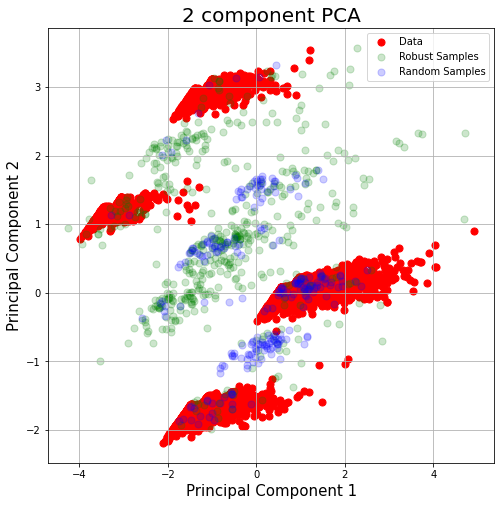

In [14]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Data', 'Robust Samples', 'Random Samples']
datas = [original_data_reduced, transformed_ctgan_pca, transformed_vanilla_pca]
colors = ['r', 'g', 'b']
for data, color in zip(datas,colors):
    ax.scatter(data[:,0]
               , data[:,1]
               , c = color
               , s = 50,alpha=(0.2 if color !='r' else 1.0))
ax.legend(targets)
ax.grid()
plt.show()

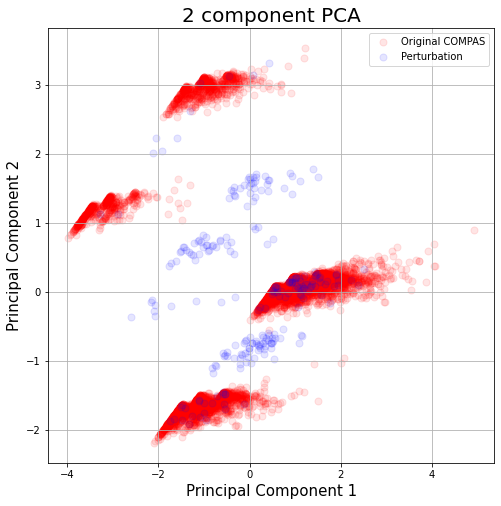

In [15]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Original COMPAS', 'Perturbation']
datas = [original_data_reduced, transformed_vanilla_pca]
colors = ['r', 'b']
for data, color in zip(datas,colors):
    ax.scatter(data[:,0]
               , data[:,1]
               , c = color
               , s = 50,alpha=(0.1 if color !='r' else 0.1))
ax.legend(targets)
ax.grid()
plt.show()


